In [65]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# plt.rc('font', family='Malgun Gothic') # windows
plt.rc('font', family='AppleGothic') # mac
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_pickle('../data/KOSPI_price_2011-2021.pickle')
df = df.loc[:, ["Close", "Volume"]].dropna().reset_index()
df = df[~df.Name.str.contains("인버스")].reset_index()
df

,index,Name,Date,Close,Volume
0,0,AJ네트웍스,2015-08-21,7100.0,1994022
1,1,AJ네트웍스,2015-08-24,6480.0,392831
2,2,AJ네트웍스,2015-08-25,6220.0,242730
3,3,AJ네트웍스,2015-08-26,7090.0,703721
4,4,AJ네트웍스,2015-08-27,7570.0,499913
...,...,...,...,...,...
2917214,3008271,흥아해운 14R,2018-01-02,158.0,1991440
2917215,3008272,흥아해운 14R,2018-01-03,155.0,1112688
2917216,3008273,흥아해운 14R,2018-01-04,156.0,1014035
2917217,3008274,흥아해운 14R,2018-01-05,160.0,922447


In [66]:
df_close = df.pivot(index="Date", columns="Name", values="Close")
df_volume = df.pivot(index="Date", columns="Name", values="Volume")

In [67]:
def get_largest_firms(start_date, end_date, df_volume, df_close, n_count=200):
    firm_list = np.mean(df_close.loc[start_date:end_date] * df_volume.loc[start_date:end_date]).dropna().sort_values(ascending=False).index[:n_count]
    
    return firm_list

firm_list = get_largest_firms("2016-06", "2016-12", df_volume, df_close, n_count=10)
firm_list

Index(['미래산업', '컨버즈', 'STX중공업', 'KODEX 레버리지', '삼성바이오로직스', 'KODEX 200',
       'SK하이닉스', '페이퍼코리아', 'POSCO', '삼성물산'],
      dtype='object', name='Name')

In [68]:
back_data = df_close.loc["2016-06":"2018-12", firm_list]

for i in back_data.columns[back_data.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    back_data[i].fillna(back_data[i].mean(),inplace=True)

back_data = back_data.pct_change(fill_method ='ffill')

cov_mat = back_data.cov()
cov_mat

Name,미래산업,컨버즈,STX중공업,KODEX 레버리지,삼성바이오로직스,KODEX 200,SK하이닉스,페이퍼코리아,POSCO,삼성물산
Name,,,,,,,,,,
미래산업,0.000625,0.000090,0.000123,0.000088,0.000009,0.000044,0.000048,0.000071,0.000107,0.000050
컨버즈,0.000090,0.003491,0.000042,0.000104,0.000137,0.000052,0.000027,0.000138,-0.000031,0.000081
STX중공업,0.000123,0.000042,0.003517,0.000063,0.000063,0.000032,-0.000008,0.000034,0.000138,0.000033
KODEX 레버리지,0.000088,0.000104,0.000063,0.000244,0.000069,0.000122,0.000176,0.000054,0.000134,0.000143
삼성바이오로직스,0.000009,0.000137,0.000063,0.000069,0.001355,0.000033,0.000035,0.000013,-0.000047,0.000138
KODEX 200,0.000044,0.000052,0.000032,0.000122,0.000033,0.000062,0.000088,0.000027,0.000068,0.000072
SK하이닉스,0.000048,0.000027,-0.000008,0.000176,0.000035,0.000088,0.000473,0.000023,0.000058,0.000066
페이퍼코리아,0.000071,0.000138,0.000034,0.000054,0.000013,0.000027,0.000023,0.001007,0.000014,0.000019
POSCO,0.000107,-0.000031,0.000138,0.000134,-0.000047,0.000068,0.000058,0.000014,0.000416,0.000058


In [82]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

class RiskParity:
    def __init__(self, df):
        
        # 일평균 수익률을 연 단위로 환산한 후, 이때의 공분산
#         self.cov_mat = data.reset_index().pivot(index='Date', columns='Name', values='Change').cov().to_numpy() * 252 
        self.df = df
        self.firm_list = self.df.columns.values
        self.cov_mat = df.cov().values
        self.std = df.std()
        
        self.initial_weights = np.repeat(1 / self.cov_mat.shape[0], self.cov_mat.shape[0])
        self.constraints = ({"type": "eq", "fun": RiskParity.weight_summation_constraint,
                            "type": "ineq", "fun": RiskParity.weight_bound_constraint})
        self.options = {"ftol": 1e-20, "maxiter": 1000}
        
        
    def optimize(self):
        self.results = minimize(fun=RiskParity.objective_function,
                                x0=self.initial_weights, 
                                method='SLSQP', 
                                constraints=self.constraints,
                                options=self.options,
                                args=self.cov_mat)

        
    @staticmethod
    def objective_function(x, cov_mat):
        variance = x.T @ cov_mat @ x
        sigma = variance ** 0.5
        mrc = 1 / sigma * (cov_mat @ x)
        rc = x * mrc
        a = np.reshape(rc, (len(rc), 1))
        risk_diff = a - a.T
        squared_risk_diff_summation = np.sum(np.square(np.ravel(risk_diff)))

        return squared_risk_diff_summation


    @staticmethod
    def weight_summation_constraint(x):
        return x.sum() - 1.0


    @staticmethod
    def weight_bound_constraint(x):
        return x
    
    
    def plot(self):
        plt.figure(figsize=(15, 10))

        plt.subplot(2,1,1)
        plt.title("포트폴리오 비중")
        plt.bar(self.firm_list, self.results.x)
        
        plt.subplot(2,1,2)
        plt.title("종목 별 변동성")
        plt.bar(self.firm_list, self.std)


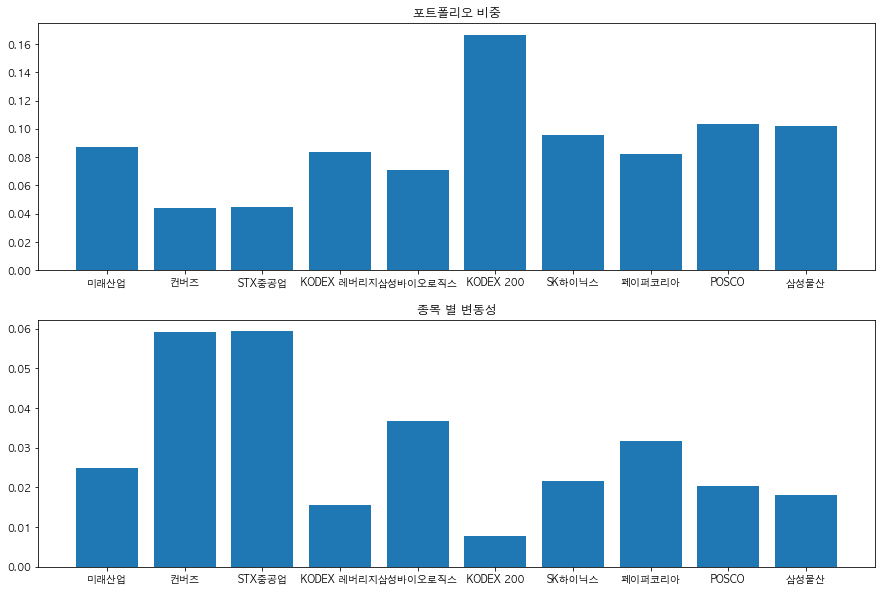

In [85]:
RP = RiskParity(back_data)
RP.optimize()

RP.plot()